In [61]:
import pandas as pd
import numpy as np
import scipy as sp
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

alt.data_transformers.disable_max_rows()
df_train = pd.read_pickle('../data/interim/holdout_lgbm.pck')

df_train.head()

,row_id,well_id,GR,label,GR_medfilt,GR_medfilt_lag_-50,GR_medfilt_lag_-45,GR_medfilt_lag_-40,GR_medfilt_lag_-35,GR_medfilt_lag_-30,...,diff_sum_120_GR_medfilt,abs_diff_sum_120_GR_medfilt,slope_120_GR_medfilt,mid_vs_end_120_GR_medfilt,label_0,label_1,label_2,label_3,label_4,pred
0,0.0,0.0,99.005617,0.0,94.464482,46.637029,50.925787,61.805139,90.687814,106.039949,...,-50.931602,77.278147,-1.308142,-36.594682,0.922386,0.006040,0.000746,0.057670,0.013158,0
1,1.0,0.0,105.563944,0.0,95.934506,46.637029,48.627032,59.038324,79.081603,106.039949,...,-50.931602,77.278147,-1.308787,-36.673762,0.981926,0.001552,0.000190,0.011602,0.004730,0
2,2.0,0.0,105.921065,0.0,99.005617,44.999495,47.096457,58.526148,78.165817,105.511353,...,-50.931602,77.278147,-1.307360,-36.673762,0.986701,0.001286,0.000154,0.008279,0.003580,0
3,3.0,0.0,113.513354,0.0,101.523783,44.930711,47.096457,52.904985,69.316049,104.738936,...,-50.931602,77.278147,-1.304120,-36.673762,0.987576,0.001380,0.000162,0.006880,0.004003,0
4,4.0,0.0,101.523783,0.0,102.486464,44.930711,47.096457,52.140537,67.978680,101.382792,...,-51.454614,77.801159,-1.300047,-36.275919,0.983133,0.001554,0.000176,0.010636,0.004501,0


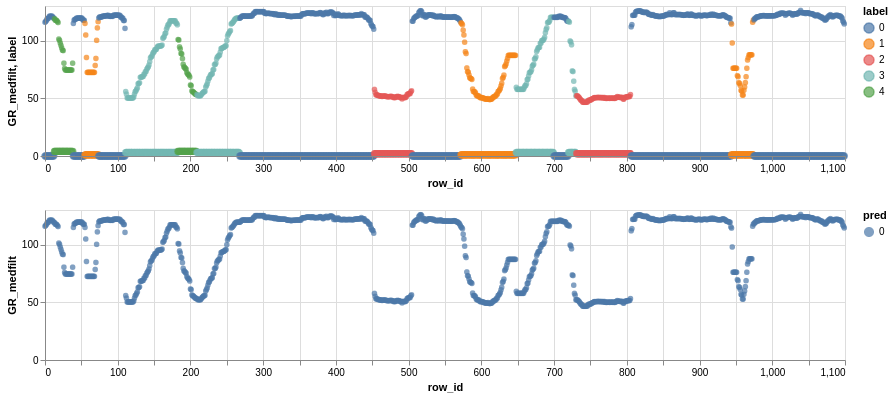

In [62]:
#well_ids = 14
#well_ids = 55
well_ids = 50

df_sub = df_train[df_train['well_id'] == well_ids]
ch_gr = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='GR_medfilt',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point()
ch_grp = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='GR_medfilt',order='row_id',color='pred:N').mark_point(size=30,filled=True)



((ch_gr + ch_lab) & ch_grp).resolve_scale(color='independent')

In [17]:
well_ids

14.0

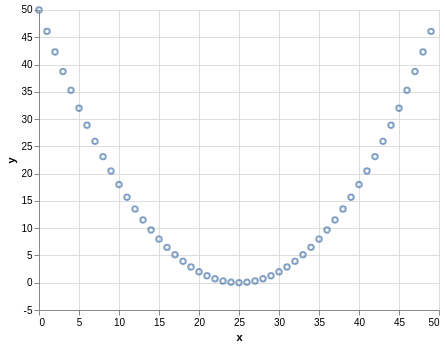

In [30]:
def make_parabolic(w,amp=50):
    x=[0,w/2,w]
    y=[amp,0,amp]
    p_coef = np.polyfit(x,y,2)
    p=np.poly1d(p_coef)
    x_new = np.arange(w)
    res = p(x_new)
    return res
    
y = make_parabolic(w=50)
tmp = pd.DataFrame({'y':y,'x':np.arange(y.shape[0])})
alt.Chart(tmp).encode(x='x',y='y').mark_point()